<a href="https://colab.research.google.com/github/palkakrzysiek/trainings-generator-python/blob/main/progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plugin to upload/download workouts
https://chrome.google.com/webstore/detail/share-your-garmin-connect/kdpolhnlnkengkmfncjdbfdehglepmff

In [217]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [218]:

def warm_up(time, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638070,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 1,
            "stepTypeKey": "warmup",
            "displayOrder": 1
        },
        "description": "Easy",
        "endCondition": {
            "conditionTypeId": 2,
            "conditionTypeKey": "time",
            "displayOrder": 2,
            "displayable": True
        },
        "endConditionValue": time,
        "targetType": {
            "workoutTargetTypeId": 1,
            "workoutTargetTypeKey": "no.target",
            "displayOrder": 1
        }
    }


def run(distance, min_speed_mps, max_speed_mps, description, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638071 + step_order,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 3,
            "stepTypeKey": "interval",
            "displayOrder": 3
        },
        "description": description,
        "endCondition": {
            "conditionTypeId": 3,
            "conditionTypeKey": "distance",
            "displayOrder": 3,
            "displayable": True
        },
        "endConditionValue": distance,
        "preferredEndConditionUnit": {
            "unitId": 2,
            "unitKey": "kilometer",
            "factor": 100000
        },
        "targetType": {
            "workoutTargetTypeId": 6,
            "workoutTargetTypeKey": "pace.zone",
            "displayOrder": 6
        },
        "targetValueOne": min_speed_mps,
        "targetValueTwo": max_speed_mps
    }

In [219]:
def workout_template(name, description, steps, estimated_duration_in_secs, estimated_distance_in_meters):
    return {
    "workoutId": 388473607,
    "ownerId": 66888980,
    "workoutName": name,
    "description": description,
    "updatedDate": "2021-09-12T14:08:55.0",
    "createdDate": "2021-09-12T14:08:55.0",
    "sportType": {
        "sportTypeId": 1,
        "sportTypeKey": "running",
        "displayOrder": 1
    },
    "estimatedDurationInSecs": estimated_duration_in_secs,
    "estimatedDistanceInMeters": estimated_distance_in_meters,
    "workoutSegments": [
        {
            "segmentOrder": 1,
            "sportType": {
                "sportTypeId": 1,
                "sportTypeKey": "running",
                "displayOrder": 1
            },
            "workoutSteps": steps
        }
    ],
    "shared": False
}

def minpkm_to_mps(val):
    return 1000 / val / 60


def format_secs(value):
    h = int(value / 60 / 60)
    m = int((value / 60) % 60)
    s = int(value % 60)
    if h > 0:
        return "{:d}:{:02d}:{:02d}".format(h,m,s)
    else:
        return "{:02d}:{:02d}".format(m,s)


def format_pace(input):
    min = int(input)
    sec = int((input % 1) * 60)
    return "{:d}:{:02d}".format(min, sec)


def format_meters_to_km(input):
    return "{:.2f}".format(input/1000.0)

# %matplotlib notebook
def plot_splits(df):

    print(df)

    ax = df.plot.area(x='covered_distance', y=['min_pace', 'pace', 'max_pace'], stacked=False, color={'min_pace':'#c9fbff', 'pace':'#3cff2e', 'max_pace':'#6e001a'})

    plt.xlim(df['covered_distance'].min(), df['covered_distance'].max() + 0.2)
    plt.ylim(max(0, df['pace'].min() - .2), df['pace'].max() + .2)
    plt.draw() # needed to recalculate labels values
    ax.set_xticklabels([ format_meters_to_km(float(x.get_text())) for x in ax.get_xticklabels()])
    ax.set_yticklabels([ format_pace(float(y.get_text())) for y in ax.get_yticklabels()])
    plt.show()



def progression_df( target_distance, split_distance, start_pace_minpkm, end_pace_minpkm, pace_toleration):

    splits_number = int(target_distance/split_distance)
    total_distance = split_distance * splits_number

    slope = (end_pace_minpkm - start_pace_minpkm) / (total_distance - split_distance)
    # - split_distance to have the last split at end disntance

    x = np.arange(0, total_distance, split_distance)
    y = start_pace_minpkm + slope * x

    df = pd.DataFrame(np.array([x, y]).transpose(), columns=['covered_distance', 'pace'])

    df['min_pace'] = df['pace'] + pace_toleration
    df['max_pace'] = df['pace'] - pace_toleration

    df['min_speed_mps'] = df['min_pace'].apply(minpkm_to_mps)
    df['max_speed_mps'] = df['max_pace'].apply(minpkm_to_mps)

    df['split_distance'] = split_distance

    plot_splits(df)


    return df

In [220]:
def progression( target_distance, split_distance, start_pace_minpkm, end_pace_minpkm, pace_toleration):

    df = progression_df(
        target_distance,
        split_distance,
        start_pace_minpkm,
        end_pace_minpkm,
        pace_toleration,
    )

    df['mps'] = 1000 / df['pace'] / 60

    df['lap'] = df.index + 1

    df['lap_time_sec'] = split_distance / df['mps']

    df['total_time'] = df['lap_time_sec'].cumsum()

    df['time_left'] = df['total_time'].values[::-1]

    df['formatted_time_left'] = df['time_left'].apply(format_secs)

    df['laps_left'] = range(len(df), 0, -1)

    df['formatted_pace'] = df['pace'].apply(format_pace)

    total_distance = df['split_distance'].sum()

    df['distance_left'] = total_distance - df['covered_distance']

    df['formatted_distance_left'] = df['distance_left'].apply(lambda dis: format_meters_to_km(dis))


    df['formatted_min_pace'] = df['min_pace'].apply(format_pace)
    df['formatted_max_pace'] = df['max_pace'].apply(format_pace)

    df['split_time'] = split_distance

    df['description'] = df.apply(lambda row: ">{:s}< | {:d} lap | {:s} | {:s}km".format(row['formatted_pace'], row['laps_left'], row['formatted_time_left'], row['formatted_distance_left']), axis=1)



    steps = list(df.apply(lambda row: run(distance=split_distance, min_speed_mps=row['min_speed_mps'], max_speed_mps=row['max_speed_mps'], description=row['description'], step_order=row['lap'] + 1), axis=1).values)

    steps.insert(0, warm_up(
        time=120,
        step_order=1
    ))


    print(steps)

    name = "{:s}km {:s}->{:s}".format(format_meters_to_km(total_distance), format_pace(start_pace_minpkm), format_pace(end_pace_minpkm))
    print(name)
    # description = str(split_distance) + "m * " + str(splits_number) + " splits, est. time " + df['formatted_time_left'][0]
    # print(description)
    description = 'progression' # TODO


    est_time_sec = int(df['time_left'][0])

    return workout_template(
        name=name,
        description=description,
        steps=steps,
        estimated_duration_in_secs=est_time_sec,
        estimated_distance_in_meters=total_distance
    )

    covered_distance  pace  min_pace  max_pace  min_speed_mps  max_speed_mps  \
0               0.00  6.75   7.08334   6.41666       2.352939       2.597405   
1             333.33  6.70   7.03334   6.36666       2.369666       2.617804   
2             666.66  6.65   6.98334   6.31666       2.386633       2.638525   
3             999.99  6.60   6.93334   6.26666       2.403844       2.659577   
4            1333.32  6.55   6.88334   6.21666       2.421305       2.680968   
5            1666.65  6.50   6.83334   6.16666       2.439022       2.702706   
6            1999.98  6.45   6.78334   6.11666       2.457000       2.724799   
7            2333.31  6.40   6.73334   6.06666       2.475245       2.747256   
8            2666.64  6.35   6.68334   6.01666       2.493763       2.770086   
9            2999.97  6.30   6.63334   5.96666       2.512560       2.793299   
10           3333.30  6.25   6.58334   5.91666       2.531643       2.816905   
11           3666.63  6.20   6.53334   5

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator


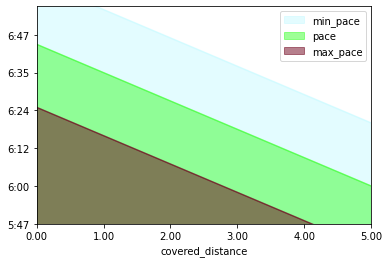

[{'type': 'ExecutableStepDTO', 'stepId': 2698638070, 'stepOrder': 1, 'stepType': {'stepTypeId': 1, 'stepTypeKey': 'warmup', 'displayOrder': 1}, 'description': 'Easy', 'endCondition': {'conditionTypeId': 2, 'conditionTypeKey': 'time', 'displayOrder': 2, 'displayable': True}, 'endConditionValue': 120, 'targetType': {'workoutTargetTypeId': 1, 'workoutTargetTypeKey': 'no.target', 'displayOrder': 1}}, {'type': 'ExecutableStepDTO', 'stepId': 2698638073, 'stepOrder': 2, 'stepType': {'stepTypeId': 3, 'stepTypeKey': 'interval', 'displayOrder': 3}, 'description': '>6:45< | 16 lap | 33:59 | 5.33km', 'endCondition': {'conditionTypeId': 3, 'conditionTypeKey': 'distance', 'displayOrder': 3, 'displayable': True}, 'endConditionValue': 333.33, 'preferredEndConditionUnit': {'unitId': 2, 'unitKey': 'kilometer', 'factor': 100000}, 'targetType': {'workoutTargetTypeId': 6, 'workoutTargetTypeKey': 'pace.zone', 'displayOrder': 6}, 'targetValueOne': 2.3529389619398007, 'targetValueTwo': 2.5974052960055025}, {'

'{"workoutId": 388473607, "ownerId": 66888980, "workoutName": "5.33km 6:45->6:00", "description": "progression", "updatedDate": "2021-09-12T14:08:55.0", "createdDate": "2021-09-12T14:08:55.0", "sportType": {"sportTypeId": 1, "sportTypeKey": "running", "displayOrder": 1}, "estimatedDurationInSecs": 2039, "estimatedDistanceInMeters": 5333.28, "workoutSegments": [{"segmentOrder": 1, "sportType": {"sportTypeId": 1, "sportTypeKey": "running", "displayOrder": 1}, "workoutSteps": [{"type": "ExecutableStepDTO", "stepId": 2698638070, "stepOrder": 1, "stepType": {"stepTypeId": 1, "stepTypeKey": "warmup", "displayOrder": 1}, "description": "Easy", "endCondition": {"conditionTypeId": 2, "conditionTypeKey": "time", "displayOrder": 2, "displayable": true}, "endConditionValue": 120, "targetType": {"workoutTargetTypeId": 1, "workoutTargetTypeKey": "no.target", "displayOrder": 1}}, {"type": "ExecutableStepDTO", "stepId": 2698638073, "stepOrder": 2, "stepType": {"stepTypeId": 3, "stepTypeKey": "interval

In [221]:
workout = progression(
    target_distance = 5400,
    split_distance = 333.33,
    start_pace_minpkm = 6.75,
    end_pace_minpkm = 6,
    pace_toleration = 0.33334
)


json.dumps(workout)